# Question 5

This script designs a Blackman-windowed differentiator filter and explores some of its properties.

In [139]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from a2_config import A2_ROOT, SAVEFIG_CONFIG

In [140]:
# Define filter specifications

N_TAPS = 25         # number of filter taps
F_SAMP = 50         # sampling frequency, kHz
F_BAND = [0, 20]    # operating frequency range, kHz

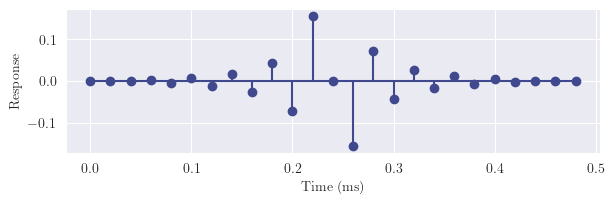

In [147]:
import scipy.signal as signal

def plot_impz(t, coeffs, fname=None):
    fig, ax = plt.subplots(figsize=(6, 2))
    fig.tight_layout()
    plt.stem(t, coeffs, linefmt="C0", basefmt="C0")
    # Axis labels
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Response")
    # Save or just short
    if fname:
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

# Define differentiator filter
taps = signal.remez(N_TAPS, F_BAND, [1], type="differentiator", fs=F_SAMP)

t = np.arange(0, N_TAPS/F_SAMP, 1/F_SAMP)
plot_impz(t, taps, fname="q5_diff_impz.png")

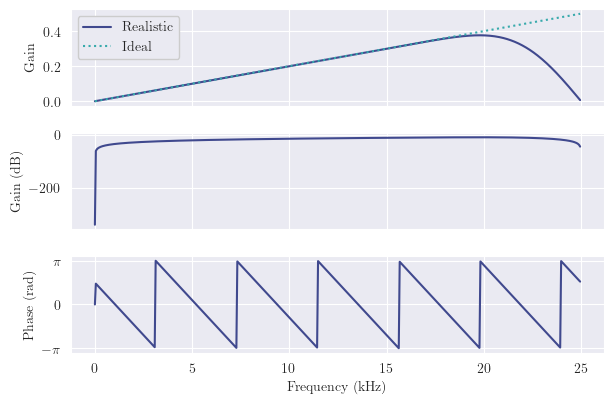

In [149]:
from scipy.fft import fft, ifft
from scipy.signal.windows import blackman

# Helper function for converting frequency response to dB scale
dB = lambda x: 20 * np.log10(x)

def plot_freqz(w, h, fname=None):
    """Plot frequency response and overlay filter requirements."""
    fig, axs = plt.subplots(3, sharex=True, figsize=(6, 4))
    fig.tight_layout()
    sns.lineplot(x=w, y=np.abs(h), ax=axs[0], label="Realistic")
    sns.lineplot(x=w, y=0.02 * w, ax=axs[0], ls=":", label="Ideal")
    sns.lineplot(x=w, y=dB(np.abs(h)), ax=axs[1])
    sns.lineplot(x=w, y=np.angle(h), ax=axs[2])
    # Axis labels
    axs[0].set_ylabel("Gain")
    axs[0].legend(framealpha=1)
    axs[1].set_ylabel("Gain (dB)")
    axs[2].set_xlabel("Frequency (kHz)")
    axs[2].set_ylabel("Phase (rad)")
    axs[2].set_yticks([-np.pi, 0, np.pi])
    axs[2].set_yticklabels(["$-\pi$", "0", "$\pi$"])
    # Save or just show
    if fname:
        fig.savefig(Path(A2_ROOT, "output", fname), **SAVEFIG_CONFIG)
    plt.show()

# Apply Blackman window
f, H_blackman = signal.freqz(taps * blackman(N_TAPS), [1], fs=F_SAMP)
plot_freqz(f, H_blackman, fname="q5_diff_freqz.png")

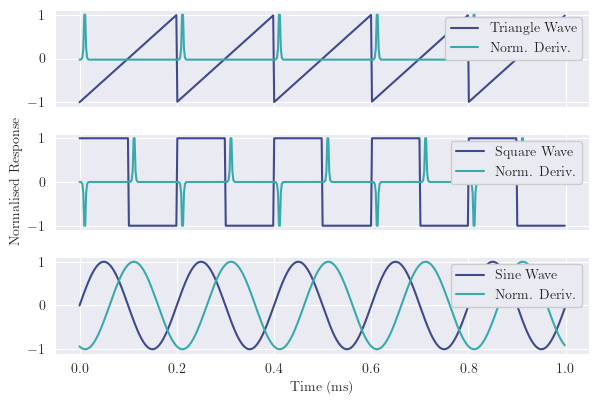

In [145]:
# Generate sample "continuous" functions to test the differentiator filter
t = np.linspace(0, 1, 512, endpoint=False)
t_tri = signal.sawtooth(2 * np.pi * 5 * t)
t_sqr = signal.square(2 * np.pi * 5 * t)
t_sin = np.sin(2 * np.pi * 5 * t)

# Apply the differentiator filter
filt_tri = ifft(fft(t_tri) * H_blackman)
filt_sqr = ifft(fft(t_sqr) * H_blackman)
filt_sin = ifft(fft(t_sin) * H_blackman)

# Plot unfiltered and filtered comparison
normalise = lambda arr: arr.real / max(np.abs(arr.real))
fig, axs = plt.subplots(3, sharex=True, figsize=(6, 4))
fig.tight_layout()
axs[0].plot(t, t_tri, label="Triangle Wave")
axs[0].plot(t, normalise(filt_tri), label="Norm. Deriv.")
axs[1].plot(t, t_sqr, label="Square Wave")
axs[1].plot(t, normalise(filt_sqr), label="Norm. Deriv.")
axs[2].plot(t, t_sin, label="Sine Wave")
axs[2].plot(t, normalise(filt_sin), label="Norm. Deriv.")
# Axis labels
axs[2].set_xlabel("Time (ms)")
axs[1].set_ylabel("Normalised Response")
axs[0].legend(loc="upper right", framealpha=1)
axs[1].legend(loc="upper right", framealpha=1)
axs[2].legend(loc="upper right", framealpha=1)

fname = Path(A2_ROOT, "output", "q5_diff_applied.png")
fig.savefig(fname, **SAVEFIG_CONFIG)